In [8]:
from amalearn.reward import GaussianReward, RewardBase
from amalearn.agent import AgentBase
from amalearn.environment import EnvironmentBase
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import gym
import timeit

In [10]:
import random
import pprint
import io
import numpy as np
import sys
from gym.envs.toy_text import discrete
from colorama import Fore, Back, Style

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class GridworldEnv(discrete.DiscreteEnv):
  metadata = {'render.modes': ['human', 'ansi']}

  def __init__(self, shape=[10,10]):
    if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
        raise ValueError('shape argument must be a list/tuple of length 2')
        
    self.shape = shape

    nS = np.prod(shape)
    nA = 4

    MAX_Y = shape[0]
    MAX_X = shape[1]

    P = {}
    grid = np.arange(nS).reshape(shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      P[s] = {a : [] for a in range(nA)}

      #Reaching target
      is_done = lambda s: s == 0

      #Due to existance of walls, these moves are not available
      no_up = lambda s: s in [44,73,74]
      no_down = lambda s: s in [23,24,54]
      no_left = lambda s: s in [44,35,54,65]
      no_right = lambda s: s in [32,42,52,62]

      #Barries in the path
      pit = lambda s: s in [13,72,41]
      wall = lambda s: s in [43,33,53,34,64,63]

      #Rewards of each state
      reward = 15.0 if is_done(s) else -1.0
      reward = -15.0 if pit(s) else reward
      
      ns_up = s if y == 0 else s - MAX_X
      ns_right = s if x == (MAX_X - 1) else s + 1
      ns_down = s if y == (MAX_Y - 1) else s + MAX_X
      ns_left = s if x == 0 else s - 1
      
      P[s][UP] = [(1, ns_up, reward, is_done(ns_up))]
      P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
      P[s][DOWN] = [(1, ns_down, reward, is_done(ns_down))]
      P[s][LEFT] = [(1, ns_left, reward, is_done(ns_left))]

      #Terminal state
      if is_done(s):
        P[s][UP] = [(1.0, s, reward, True)]
        P[s][RIGHT] = [(1.0, s, reward, True)]
        P[s][DOWN] = [(1.0, s, reward, True)]
        P[s][LEFT] = [(1.0, s, reward, True)]

      #Encountering walls
      if no_up(s):
        P[s][UP] = [(1.0, s, -5.0 , False)]                
      if no_down(s):
        P[s][DOWN] = [(1.0, s, -5.0 , False)]                
      if no_right(s):
        P[s][RIGHT] = [(1.0, s, -5.0 , False)]  
      if no_left(s):
        P[s][LEFT] = [(1.0, s, -5.0 , False)] 

      it.iternext() 

    # Initial state distribution is uniform
    isd = np.zeros(100)
    isd[44]=1
    self.P = P

    super(GridworldEnv, self).__init__(nS, nA, P, isd)

  def _render(self, mode='human', close=False):
    if close:
      return

    outfile = io.StringIO() if mode == 'ansi' else sys.stdout

    grid = np.arange(self.nS).reshape(self.shape)
    it = np.nditer(grid, flags=['multi_index'])

    while not it.finished:
      s = it.iterindex
      y, x = it.multi_index

      if self.s == s and not s==0:
        output =  Back.CYAN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL if s not in [13,72,41] else Back.BLUE + Style.BRIGHT + Fore.WHITE + "  웃 " + Style.RESET_ALL
      elif s == 0:
          output = Back.GREEN + Style.BRIGHT + Fore.WHITE + "     " + Style.RESET_ALL if not self.s==0 else Back.GREEN + Style.BRIGHT + Fore.WHITE +  "  웃 " + Style.RESET_ALL
      elif s in [13,72,41]:
          output = Back.BLUE + "     " + Style.RESET_ALL
      elif s in [43,33,53,34,64,63]:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +   "  █  "  + Style.RESET_ALL
      else:
          output = Back.CYAN + Style.BRIGHT + Fore.BLACK +  "  .  " + Style.RESET_ALL

      if x == 0:
          output = output.lstrip()
      if x == self.shape[1] - 1:
          output = output.rstrip()

      outfile.write(output)

      if x == self.shape[1] - 1:
          outfile.write("\n")

      it.iternext()

In [14]:
class Agent_xpSARSA_2s(AgentBase):
    def __init__(self, id, environment, action_count, state_count, alpha, epsilon):
        super(Agent_xpSARSA_2s, self).__init__(id, environment)
        self.alpha = alpha
        #self.policy = np.random.choice([i for i in range(action_count)],state_count)
        self.Q_sa = np.zeros((action_count,state_count))
        self.action_count = action_count
        self.state_count = state_count
        self.epsilon = epsilon
        self.env = environment
        self.R_avg = []
        self.R_sum = []
        if epsilon == 0:
            self.change_epsilon = True
        else:
            self.change_epsilon = False
            self.epsilon = epsilon
        if alpha == 0:
            self.change_alpha = True
        else:
            self.change_alpha = False
            self.alpha = alpha
    
    def main_loop(self):
        gama = 0.9
        for k in range(1000):
            if k%100 == 0:
                print(k)
            if self.change_epsilon:
                self.epsilon = 100/(100+k)
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            state = np.random.choice([i for i in range(self.state_count)])
            p = random.random()
            if p< 1-self.epsilon:
                action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
            else:
                action = np.random.choice([i for i in range(self.action_count)])
            if self.change_alpha:
                self.alpha = 100/(1000+k)
            flag = False
            R = []
            length = 0
            while True:
                length = length + 1
                if length > 2000:
                    break
                _, state_p, reward, done = self.env.P[state][action][0]
                R.append(reward)
                if done:
                    if flag:
                        break
                    else:
                        flag = True
                p = random.random()
                if p< 1-self.epsilon:
                    action_p = np.argmax([self.Q_sa[i][state_p] for i in range(self.action_count)])
                else:
                    action_p = np.random.choice([i for i in range(self.action_count)])
                _, state_p2, reward2, donep = self.env.P[state_p][action_p][0]
                R.append(reward2)
                sum_Q = np.sum([self.Q_sa[i][state_p2] for i in range(self.action_count)])
                sum_Q = sum_Q*self.epsilon/self.action_count + (1-self.epsilon)*np.max([self.Q_sa[i][state_p2] for i in range(self.action_count)])
                self.Q_sa[action][state] = self.Q_sa[action][state] + self.alpha*(reward+gama*reward2+ gama*gama*(sum_Q)- self.Q_sa[action][state])
                state = state_p2
                p = random.random()
                if p< 1-self.epsilon:
                    action = np.argmax([self.Q_sa[i][state] for i in range(self.action_count)])
                else:
                    action = np.random.choice([i for i in range(self.action_count)])

                '''if donep:
                    if flag:
                        break
                    else:
                        flag = True'''
            self.R_avg.append(np.mean(R))
            self.R_sum.append(np.sum(R))
    
    def take_action(self) -> (object, float, bool, object):
        index_selected_arm = 0
        obs, Ri, d, i = self.environment.step(index_selected_arm)
        #self.environment.update_selected_arm(index_selected_arm, Ri)
        #print(obs, r, d, i)
        self.environment.render()
        return obs, Ri, d, i

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
dynamic time = 60.043986946002406
constatnt time = 14.844310184998903


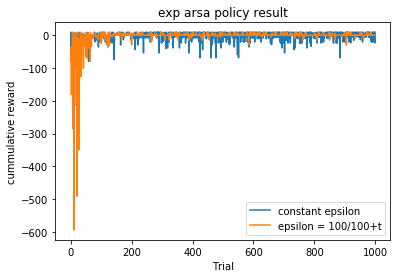

In [127]:
env =  GridworldEnv()
env.reset()
#print(env.P)
agent_sarsa_2xp = Agent_xpSARSA_2s('4', env, 4,100,0,0.5)
t = timeit.default_timer()
agent_sarsa_2xp.main_loop()
t1_sarsa2xp = timeit.default_timer() - t
agent_sarsa_2xp2 = Agent_xpSARSA_2s('4', env, 4,100,0,0)
t = timeit.default_timer()
agent_sarsa_2xp2.main_loop()
t2_sarsa2xp = timeit.default_timer() - t
print("dynamic time = "+str(t2_sarsa2xp))

print("constatnt time = "+str(t1_sarsa2xp))
plt.plot([i for i in range(1000)],agent_sarsa_2xp.R_sum, label="constant epsilon")
plt.plot([i for i in range(1000)],agent_sarsa_2xp2.R_sum, label="epsilon = 100/100+t")
plt.xlabel("Trial")
plt.ylabel("cummulative reward")
plt.title("exp arsa policy result")
plt.legend()
plt.show()